In [1]:
!pip install natasha
!pip install nltk
!pip install matplotlib
!pip install seaborn
!pip install setuptools
import sqlite3
import natasha
import nltk
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame
nltk.download('stopwords')

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     -------------------- ------------------- 30.7/61.0 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 61.0/61.0 kB 651.3 kB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparin

Matplotlib is building the font cache; this may take a moment.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Eve\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [3]:
import json
with open('articles.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

titles = [article["title"] for article in data]
texts = [article["body"] for article in data]
articles_dict = dict(zip(titles, texts))

In [4]:
from natasha import (
    Segmenter,
    MorphVocab,

    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,

    PER,
    NamesExtractor,

    Doc
)

segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)

from ipymarkup import show_dep_ascii_markup as show_markup
articles = list(articles_dict.values())
article = articles[19]


doc = Doc(str(article))
doc.segment(segmenter)
doc.parse_syntax(syntax_parser)
doc.tag_morph(morph_tagger)

for sentence in doc.sents: 
  sentence.syntax.print()



              ┌────────────► [                punct
              │           ┌► '                punct
┌─┌─┌─────────│   ┌─────┌─└─ Фото             
│ │ │         │   │     │ ┌► :                punct
│ │ │         │ ┌─│ ┌─┌─└►└─ David            parataxis
│ │ │         │ │ │ │ │ └──► W                flat:foreign
│ │ │         │ │ │ │ └────► Cerny            flat:foreign
│ │ │         │ │ │ │     ┌► /                punct
│ │ │         │ │ │ └──►┌─└─ Reuters          flat:foreign
│ │ │         │ │ │     └──► '                punct
│ │ │         │ │ │     ┌──► ,                punct
│ │ │         │ │ │     │ ┌► '                punct
│ │ │ ┌─┌─────│ │ └────►└─└─ Чиновники        conj
│ │ │ │ │     │ │     ┌─└──► Евросоюза        nmod
│ │ │ │ │     │ │     │   ┌► (                punct
│ │ │ │ │     │ │     └►┌─└─ ЕС               parataxis
│ │ │ │ │     │ │       └──► )                punct
│ │ │ │ │     │ │         ┌► и                cc
│ │ │ │ │     │ └──────►┌─└─ правительств    

Получаем токены и леммизируем слова

In [7]:
for sentence in doc.sents:
  for token in sentence.tokens:
    print(token)

for sentence in doc.sents:
  for token in sentence.tokens:
    token.lemmatize(morph_vocab)
  lemmas = {_.text: _.lemma for _ in sentence.tokens}
  print(lemmas.items())

DocToken(stop=1, text='[', id='1_1', head_id='1_22', rel='punct', pos='PUNCT', lemma='[')
DocToken(start=1, stop=2, text="'", id='1_2', head_id='1_3', rel='punct', pos='PUNCT', lemma="'")
DocToken(start=2, stop=6, text='Фото', id='1_3', head_id='1_0', rel='root', pos='NOUN', feats=<Inan,Nom,Neut,Sing>, lemma='фото')
DocToken(start=6, stop=7, text=':', id='1_4', head_id='1_5', rel='punct', pos='PUNCT', lemma=':')
DocToken(start=8, stop=13, text='David', id='1_5', head_id='1_3', rel='parataxis', pos='PROPN', feats=<Yes>, lemma='david')
DocToken(start=14, stop=15, text='W', id='1_6', head_id='1_5', rel='flat:foreign', pos='X', feats=<Yes>, lemma='w')
DocToken(start=16, stop=21, text='Cerny', id='1_7', head_id='1_5', rel='flat:foreign', pos='X', feats=<Yes>, lemma='cerny')
DocToken(start=22, stop=23, text='/', id='1_8', head_id='1_9', rel='punct', pos='PUNCT', lemma='/')
DocToken(start=24, stop=31, text='Reuters', id='1_9', head_id='1_5', rel='flat:foreign', pos='X', feats=<Yes>, lemma='re

Объединяем слова в пары

In [8]:
pairs = {}
for sentence in doc.sents:
    nsubj = root = ''
    for token in sentence.tokens:
        token.lemmatize(morph_vocab)
        if token.rel in {"nsubj", "root"}:
            if token.rel == "nsubj":
                nsubj = token.lemma
            elif token.rel == "root":
                root = token.lemma
            if nsubj and root:
                pairs[nsubj] = root

all_pairs = []
for article in articles:
  doc = Doc(str(article))
  doc.segment(segmenter)
  doc.parse_syntax(syntax_parser)
  doc.tag_morph(morph_tagger)
  for sentence in doc.sents:
    nsubj = root = ''
    for token in sentence.tokens:
      token.lemmatize(morph_vocab)
      if token.rel == "nsubj":
        nsubj = token.lemma
      if token.rel == 'root':
        root = token.lemma
      if nsubj and root:
        all_pairs.append((nsubj, root))

print(all_pairs)
all_pairs_count = Counter(all_pairs)
all_pairs_count.most_common(20)

[('актриса', 'скончаться'), ('актриса', 'скончаться'), ('актриса', 'скончаться'), ('актриса', 'скончаться'), ('актриса', 'скончаться'), ('актриса', 'скончаться'), ('похороны', 'отмечаться'), ('похороны', 'отмечаться'), ('похороны', 'отмечаться'), ('похороны', 'отмечаться'), ('похороны', 'отмечаться'), ('похороны', 'отмечаться'), ('похороны', 'отмечаться'), ('коллега', 'проститься'), ('коллега', 'проститься'), ('коллега', 'проститься'), ('коллега', 'проститься'), ('коллега', 'проститься'), ('коллега', 'проститься'), ('коллега', 'проститься'), ('коллега', 'проститься'), ('коллега', 'проститься'), ('коллега', 'проститься'), ('коллега', 'проститься'), ('коллега', 'проститься'), ('коллега', 'проститься'), ('коллега', 'проститься'), ('коллега', 'проститься'), ('коллега', 'проститься'), ('коллега', 'проститься'), ('коллега', 'проститься'), ('коллега', 'проститься'), ('коллега', 'проститься'), ('коллега', 'проститься'), ('актриса', 'проститься'), ('актриса', 'служить'), ('актриса', 'служить'),

[(('сделка', 'состоять'), 71),
 (('бронетранспортер', 'машина'), 50),
 (('депутат', 'добавить'), 49),
 (('следователь', 'завести'), 40),
 (('гражданин', 'отправить'), 38),
 (('риа', 'писать'), 37),
 (('англосакс', 'спонсировать'), 37),
 (('канал', 'восстановить'), 36),
 (('the', 'запретить'), 36),
 (('вашингтон', 'направить'), 32),
 (('она', 'поделиться'), 30),
 (('зампред', 'сообщить'), 28),
 (('израиль', 'объявить'), 27),
 (('публикация', 'появиться'), 27),
 (('россия', 'ратифицировать'), 26),
 (('она', 'знать'), 25),
 (('вилла', 'стать'), 25),
 (('украина', 'работать'), 25),
 (('риа', 'передавать'), 24),
 (('ес', 'хотеть'), 24)]

Часто встречающиеся слова

In [9]:
import string
filtered = []
punctuation = set(string.punctuation + '«»—' + string.digits + 'n')
stop_words = set(stopwords.words('russian'))
for article in articles:
  doc = Doc(str(article))
  doc.segment(segmenter)
  doc.parse_syntax(syntax_parser)
  doc.tag_morph(morph_tagger)
  for sentence in doc.sents:
    for token in sentence.tokens:
      token.lemmatize(morph_vocab)
      if token.lemma not in punctuation and token.lemma not in stop_words:
        filtered.append(token.lemma)

filtered_count = Counter(filtered)
filtered_count.most_common(20)

[('это', 35),
 ('россия', 23),
 ('российский', 20),
 ('фото', 18),
 ('год', 17),
 ('ранее', 15),
 ('сша', 14),
 ('заявить', 14),
 ('украина', 13),
 ('украинский', 13),
 ('риа', 12),
 ('новость', 12),
 ('который', 12),
 ('американский', 11),
 ('газ', 11),
 ('также', 10),
 ('газа', 10),
 ('слово', 10),
 ('свой', 10),
 ('рф', 10)]

Наиболее встречающиеся пары


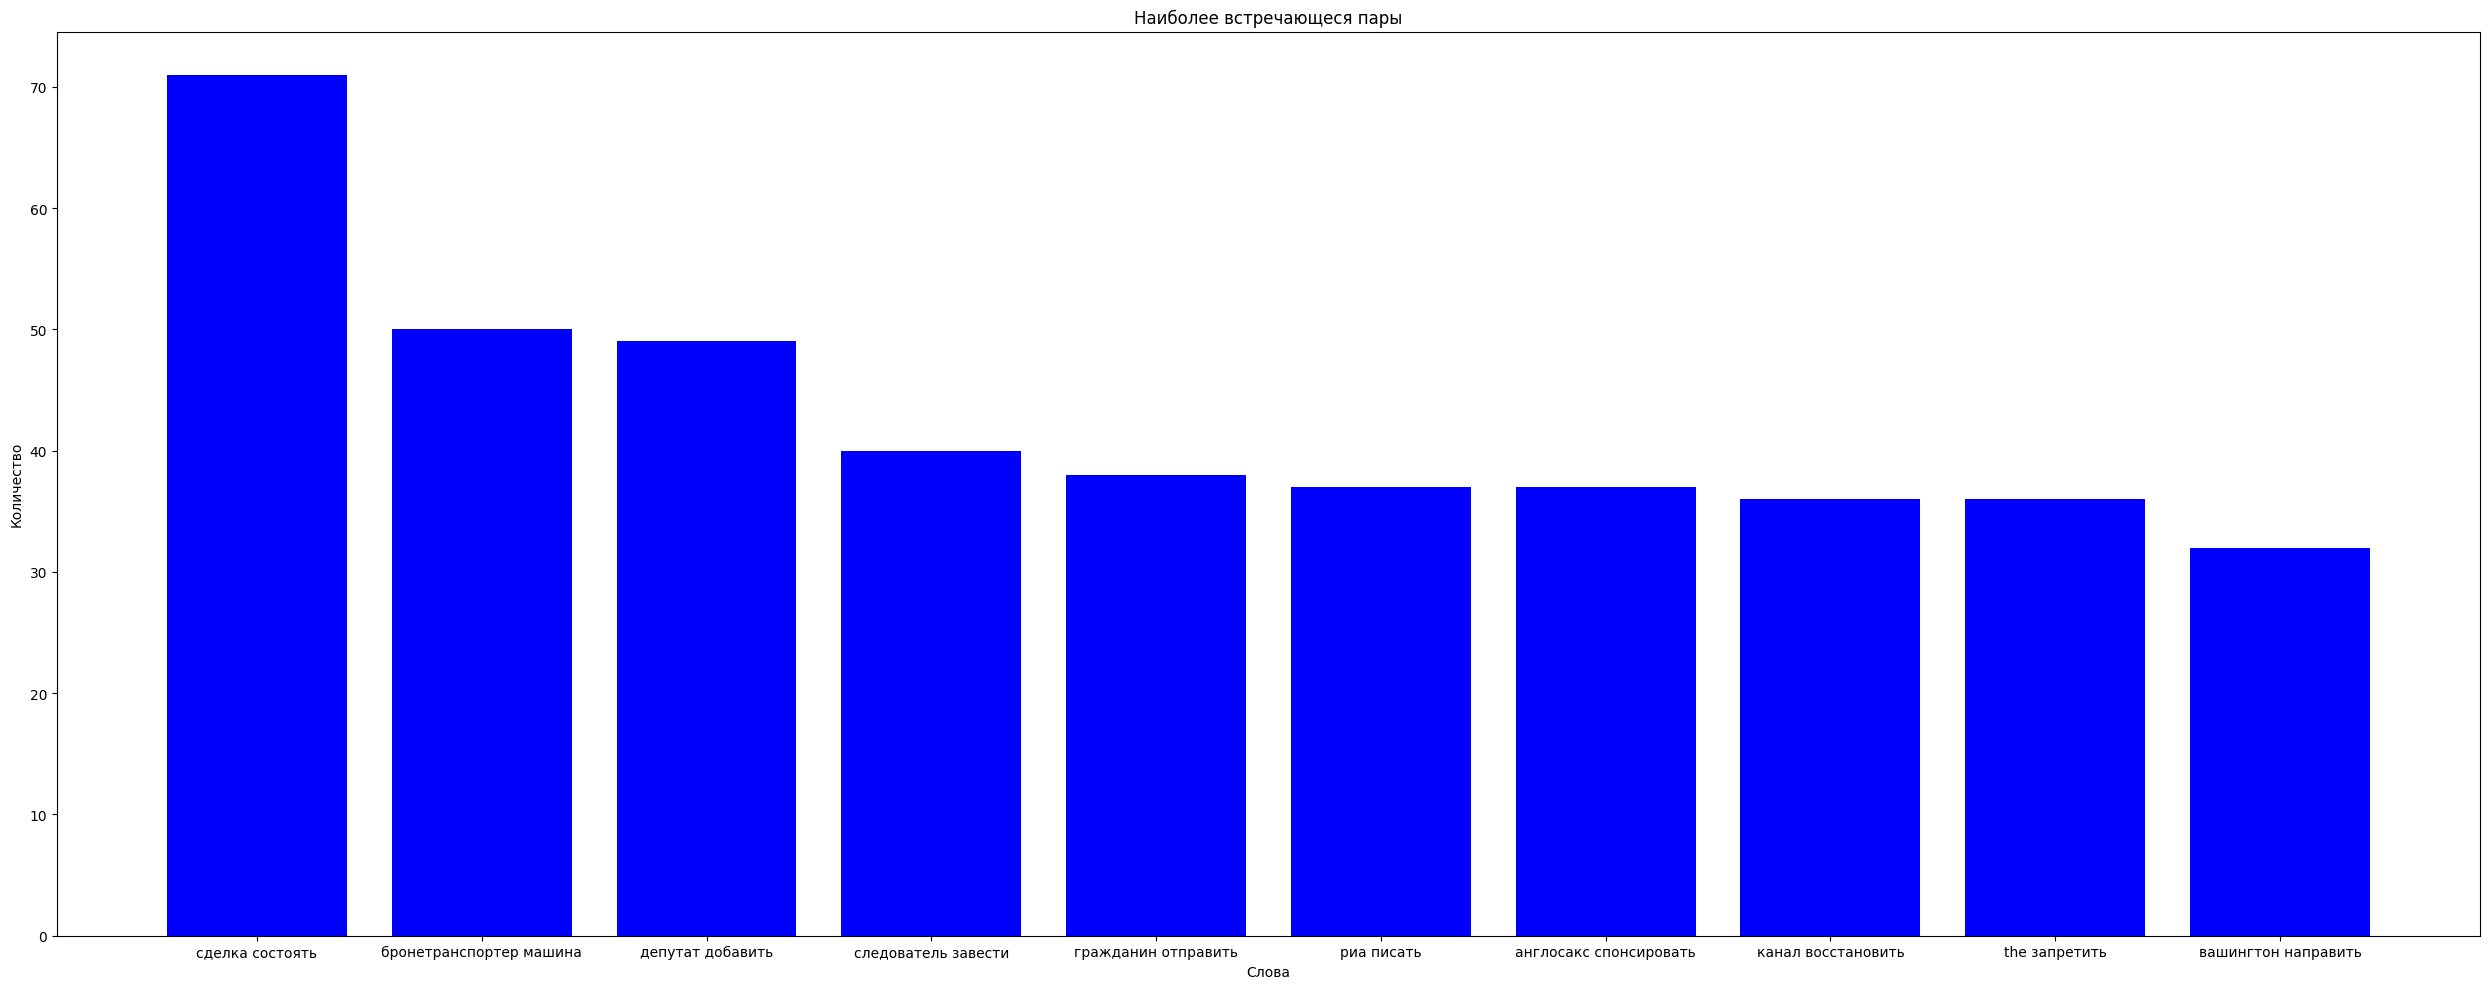

In [15]:
pairs = [pair[0][0] + ' ' + pair[0][1] for pair in all_pairs_count.most_common(10)]
count = [pair[1] for pair in all_pairs_count.most_common(10)]

plt.figure(figsize=(25, 10))
plt.bar(pairs, count, color = 'blue')
plt.title("Наиболее встречающеся пары")
plt.ylabel("Количество")
plt.xlabel("Слова")
plt.tight_layout()
plt.show()

Популярные слова

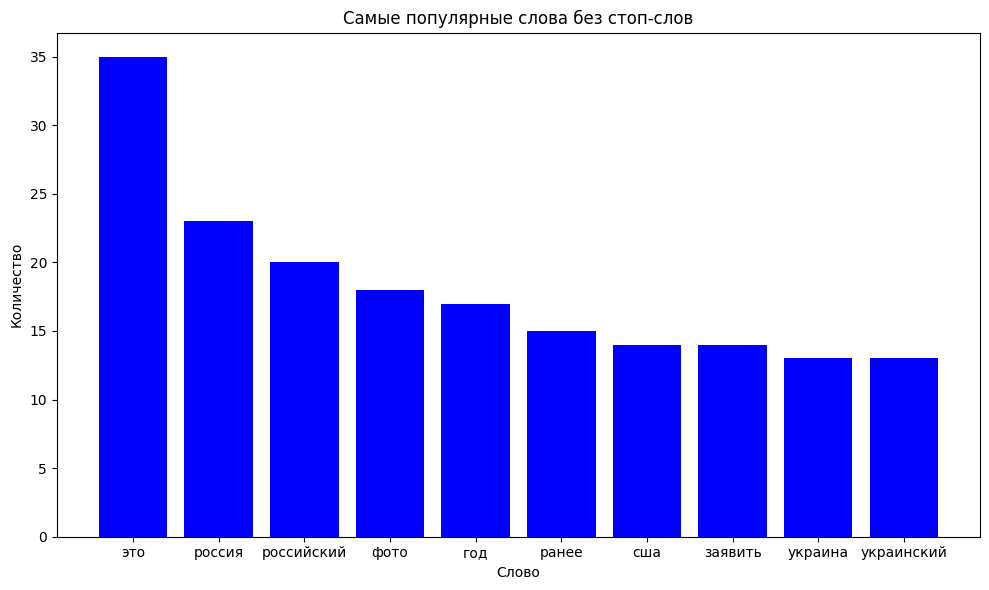

In [16]:
words = [pair[0] for pair in filtered_count.most_common(10)]
count = [pair[1] for pair in filtered_count.most_common(10)]

plt.figure(figsize=(10, 6))
plt.bar(words, count, color = 'blue')
plt.title("Самые популярные слова без стоп-слов")
plt.ylabel("Количество")
plt.xlabel("Слово")
plt.tight_layout()
plt.show()